In [36]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import warnings
import os
import sweetviz as sv
from IPython.display import IFrame
import time
import requests
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

# データ取得

In [37]:
# Binanceのインスタンスを作成（レートリミットを有効化）
exchange = ccxt.binance({
    'enableRateLimit': True,
})

# BTC/USDTのデータを取得
symbol = 'BTC/USDT'
timeframe = '1h'  # 15分足のデータ
since = exchange.parse8601('2020-01-01T00:00:00Z')  # データの開始日

# データを取得する関数（例外処理と進行状況の追加）
def fetch_all_ohlcv(symbol, timeframe, since):
    all_ohlcv = []
    now = exchange.milliseconds()
    while since < now:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit=1000)
            if not ohlcv:
                break
            since = ohlcv[-1][0] + 1  # タイムスタンプを更新
            all_ohlcv.extend(ohlcv)
        except Exception as e:
            print(f'An error occurred: {e}')
            # リトライのために一時停止
            time.sleep(5)
            continue
    return all_ohlcv

# データを取得
ohlcv = fetch_all_ohlcv(symbol, timeframe, since)
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# タイムスタンプを変換
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

# CSVファイルとして保存
data.to_csv('btc_usdt_1h_2018_to_now.csv', index=False)

print('Data fetching and saving completed.')

Data fetching and saving completed.


In [38]:
# データの読み込みと文字列として保存されている日時情報を日時型のデータに変換
df = pd.read_csv('btc_usdt_1h_2018_to_now.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [39]:
# タイムスタンプでソートとインデックスのリセット
df.sort_values('timestamp', inplace=True)#inplaceで新しいdataframeを作成せず元のを変更
# 列をインデックス（行ラベル）として設定
df.set_index('timestamp', inplace=True)

In [40]:
# 特徴量エンジニアリング
# 移動平均線の計算
df['SMA_10'] = df['close'].rolling(window=10).mean()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_30'] = df['close'].rolling(window=30).mean()
df['SMA_100'] = df['close'].rolling(window=100).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

# 指数移動平均線の計算
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_200'] = df['close'].ewm(span=200, adjust=False).mean()

# RSIの計算
def compute_RSI(data, time_window):
    diff = data.diff(1) #1つ前の行との違い
    up_chg = diff.clip(lower=0) #差分が負の物は0に変換
    down_chg = -diff.clip(upper=0) #差分が0より大きいものを全て0に置き換える
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean() #価格が上昇した指数移動平均
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    rs = up_chg_avg / down_chg_avg #上昇した強さと下落した強さの比率
    rsi = 100 - 100 / (1 + rs) 
    return rsi

df['RSI_14'] = compute_RSI(df['close'], 14)

# MACDの計算
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# ボリンジャーバンドの計算
df['STD_20'] = df['close'].rolling(window=20).std() #stdは標準偏差(データのばらつき度合い)を計算
df['Upper_Band'] = df['SMA_20'] + (df['STD_20'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STD_20'] * 2)

# 遅延特徴量の作成
for lag in range(1, 6): #shift(lag) は、df['close'] のデータを lag 分だけ下にシフト
    df[f'lag_{lag}'] = df['close'].shift(lag) #lag_1からlag_5 までの5つの遅延列が作成

# 時間に関する特徴量
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek #曜日は0から6の値で表される

#ATR（平均真の範囲、Average True Range）
df['TR'] = df['high'] - df['low']
df['ATR_14'] = df['TR'].rolling(window=14).mean()

#ADX（平均方向性指数、Average Directional Index）
def compute_ADX(data, period=14):
    high = data['high']
    low = data['low']
    close = data['close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr = high.combine(low, max) - low.combine(close.shift(), min)

    atr = tr.rolling(window=period).mean()

    plus_di = 100 * (plus_dm.ewm(alpha=1/period).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/period).mean() / atr))
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period).mean()
    
    return adx

df['ADX_14'] = compute_ADX(df)

#CCI（商品チャンネル指数、Commodity Channel Index）
df['TP'] = (df['high'] + df['low'] + df['close']) / 3
df['CCI_14'] = (df['TP'] - df['TP'].rolling(window=14).mean()) / (0.015 * df['TP'].rolling(window=14).std())

#OBV（オンバランスボリューム、On-Balance Volume）
df['OBV'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()

#Stochastic Oscillator（ストキャスティクス）
df['L14'] = df['low'].rolling(window=14).min()
df['H14'] = df['high'].rolling(window=14).max()
df['%K'] = 100 * (df['close'] - df['L14']) / (df['H14'] - df['L14'])
df['%D'] = df['%K'].rolling(window=3).mean()



In [41]:
# 目標変数の作成
df['return'] = df['close'].pct_change().shift(-1) #前の行とのパーセンテージの変化
df['target'] = (df['return'] > 0).astype(int) #価格が上昇したらTrue

In [42]:
# 欠損値の削除
df.dropna(inplace=True)

In [43]:
# 特徴量と目標変数の定義
features = ['open', 'high', 'low', 'close', 'volume', 'SMA_10', 'SMA_30','SMA_100', 'SMA_200',
            'EMA_20',  'EMA_200', 'RSI_14', 'MACD', 'Signal_Line',
            'Upper_Band', 'Lower_Band', 'ATR_14', 'ADX_14', 'CCI_14', 'OBV', '%K', '%D', 'hour', 'day_of_week'] + [f'lag_{lag}' for lag in range(1,6)]

X = df[features]
y = df['target'] #価格が上昇すれば1下落すれば0

In [44]:
# データの分割（時間ベースでの分割）
split_date = '2024-01-01'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

In [45]:
# LightGBM用のデータセットを作成
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# パラメータの設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_iterations' : 10000,
    'verbosity': -1,
}

# モデルの訓練
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets=[lgb_train, lgb_eval],
                num_boost_round=1000,
                callbacks=[lgb.early_stopping(stopping_rounds=50)])

# 予測の実行
print('Making predictions...')
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int)

Starting training...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.68054	valid_1's binary_logloss: 0.690215
Making predictions...


In [46]:
# モデルの評価
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.5324443222436074
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.55      0.53      3574
           1       0.54      0.52      0.53      3700

    accuracy                           0.53      7274
   macro avg       0.53      0.53      0.53      7274
weighted avg       0.53      0.53      0.53      7274



In [47]:
auc = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC Score:', auc)

ROC AUC Score: 0.5461193832332613


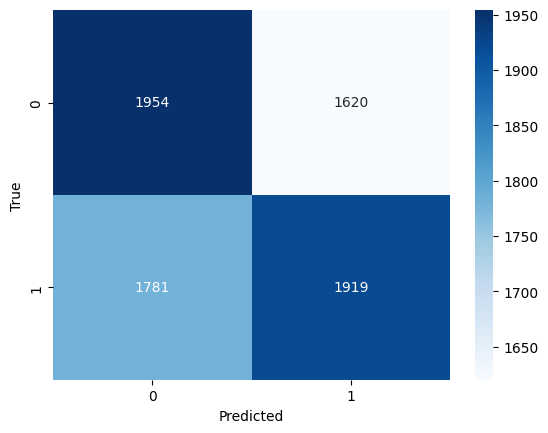

In [48]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

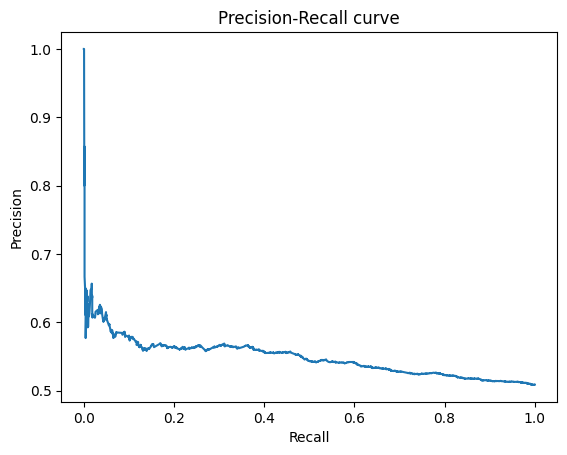

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

In [50]:
lgb_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbosity=-1)
scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validated accuracy:", scores.mean())

Cross-validated accuracy: 0.5071917564206239


Final capital: 2151.0109260680556
Sharpe Ratio: 1.414753669675422


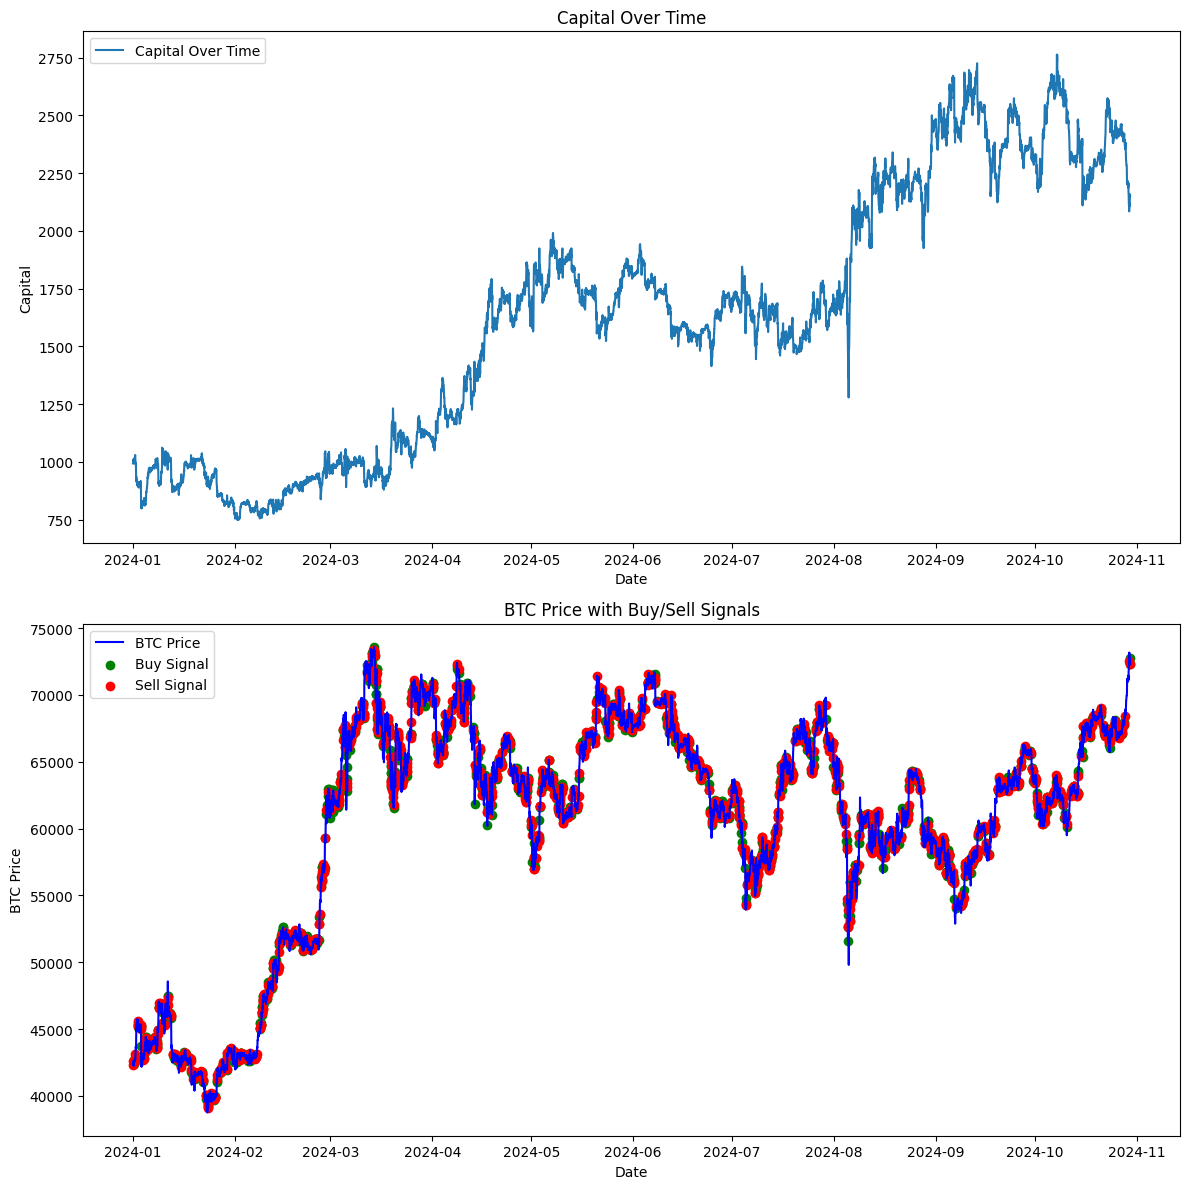

In [51]:
# 初期設定
initial_capital = 1000
capital = initial_capital  # 初期資金をリセット
capital_history = []
positions = []
buy_signals = []
sell_signals = []

leverage = 2  # レバレッジ

# 現在のポジションの状態を示す変数
current_position = 0  # 1=ロング, -1=ショート, 0=ポジションなし

# テスト期間の日付リスト
test_dates = X_test.index

for i in range(len(test_dates) - 1):
    date = test_dates[i]
    prediction = y_pred[i]
    close_price = df.loc[date, 'close']
    next_date = test_dates[i + 1]
    next_close_price = df.loc[next_date, 'close']
    
    # ポジションの決定と変更
    if prediction == 1:  # 上がると予想
        if current_position == -1:  # 現在ショートなら決済してロングに変更
            sell_signals.append((date, close_price))  # ショート決済
            current_position = 1
            buy_signals.append((next_date, next_close_price))  # ロングエントリー

        elif current_position == 0:
            current_position = 1
            buy_signals.append((next_date, next_close_price))  # ロングエントリー

        else:
            current_position = 1
        

    elif prediction == 0:  # 下がると予想
        if current_position == 1:  # 現在ロングなら決済してショートに変更
            buy_signals.append((date, close_price))  # ロング決済
            current_position = -1
            sell_signals.append((next_date, next_close_price))  # ショートエントリー

        elif current_position == 0:
            current_position = -1
            sell_signals.append((next_date, next_close_price))  # ショートエントリー

        else:
            current_position = -1

    # リターンの計算
    ret = (next_close_price - close_price) / close_price * current_position * leverage
    capital = capital * (1 + ret)
    capital_history.append(capital)
    positions.append(current_position)

# バックテスト結果のデータフレーム作成
backtest_results = pd.DataFrame(index=test_dates[:-1])
backtest_results['Capital'] = capital_history
backtest_results['Position'] = positions

# リターンの計算
backtest_results['Return'] = backtest_results['Capital'].pct_change().fillna(0)

# シャープレシオの計算（リスクフリーレートは0と仮定）
sharpe_ratio = (backtest_results['Return'].mean() / backtest_results['Return'].std()) * np.sqrt(365 * 24)

print('Final capital:', capital)
print('Sharpe Ratio:', sharpe_ratio)

# 資産推移と売買のプロット
plt.figure(figsize=(12, 12))

# 1つ目のグラフ: 資産推移のプロット
plt.subplot(2, 1, 1)
plt.plot(backtest_results.index, backtest_results['Capital'], label='Capital Over Time')
plt.title('Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

# 2つ目のグラフ: BTC価格と売買シグナルのプロット
plt.subplot(2, 1, 2)
plt.plot(df.loc[test_dates[:-1], 'close'], label='BTC Price', color='blue')

# 買いのシグナル（緑の丸）
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='o')

# 売りのシグナル（赤の丸）
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='o')

plt.title('BTC Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
# リターン計算やポジションサイズの確認
print("Return:", ret)

Return: -0.0034685300136296972


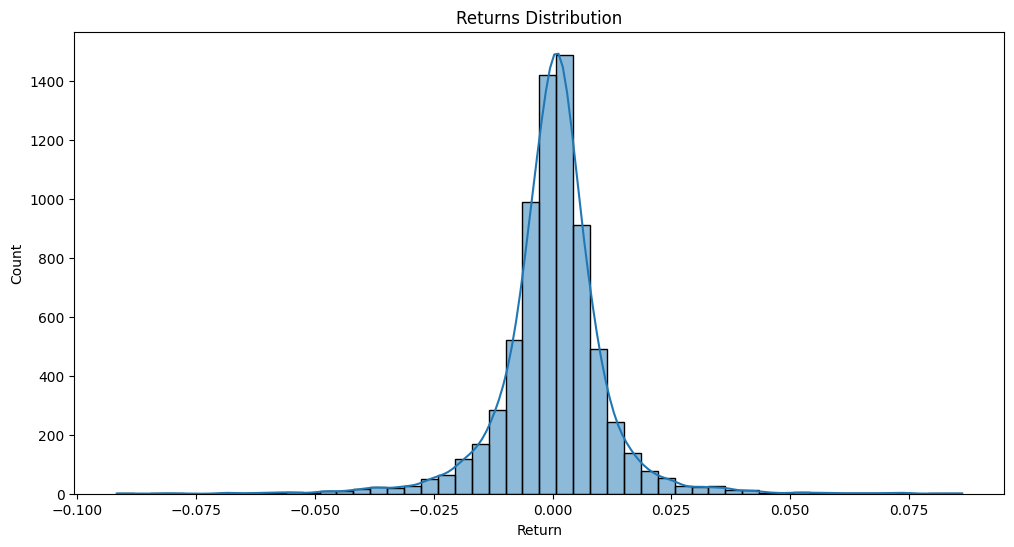

In [53]:
# リターン分布のプロット
plt.figure(figsize=(12,6))
sns.histplot(backtest_results['Return'], bins=50, kde=True)
plt.title('Returns Distribution')
plt.show()

In [54]:
backtest_results['Return']

timestamp
2024-01-01 00:00:00    0.000000
2024-01-01 01:00:00    0.001523
2024-01-01 02:00:00    0.011771
2024-01-01 03:00:00    0.003284
2024-01-01 04:00:00   -0.007829
                         ...   
2024-10-29 20:00:00   -0.001278
2024-10-29 21:00:00    0.010237
2024-10-29 22:00:00    0.002103
2024-10-29 23:00:00    0.012275
2024-10-30 00:00:00   -0.003469
Name: Return, Length: 7273, dtype: float64

In [55]:
# モデルの保存
gbm.save_model('lightgbm_btc_model.txt')

In [56]:
# モデル改良のための次のステップとして、ハイパーパラメータのチューニングを行います
# グリッドサーチによるハイパーパラメータチューニング
param_grid = {
    'num_leaves': [20, 31, 50],  # 葉の数を広げてより複雑なモデルを試す
    'learning_rate': [0.1, 0.05, 0.01],  # より小さい学習率も追加
    'max_depth': [5, 10, 15],  # モデルの深さを広げ、過学習を避ける
    'min_data_in_leaf': [20, 50],  # リーフに必要な最小データを設定し、過学習を防ぐ
    'feature_fraction': [0.7, 0.9],  # サブサンプルでの特徴量選択率
    'bagging_fraction': [0.8, 1.0],  # サブサンプルでのデータ選択率
    'bagging_freq': [1, 5]  # サブサンプルの頻度
}

# モデルのインスタンス化
gbm_cv = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbose=-1)
# グリッドサーチの実行
grid = GridSearchCV(gbm_cv, param_grid, cv=3)
grid.fit(X_train, y_train)

print('Best parameters found by grid search are:', grid.best_params_)

Best parameters found by grid search are: {'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 15, 'min_data_in_leaf': 50, 'num_leaves': 20}


In [57]:
# 最適なパラメータを取得
best_params = grid.best_params_
train_params = {**params, **best_params}

# モデルの訓練
print('Starting optimized training...')
gbm_optimized = lgb.train(train_params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          num_boost_round=1000,
                          callbacks=[lgb.early_stopping(stopping_rounds=100)])

# 予測の実行
print('Making predictions...')
y_pred_prob = gbm_optimized.predict(X_test, num_iteration=gbm_optimized.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int)

Starting optimized training...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.684267	valid_1's binary_logloss: 0.689959
Making predictions...


In [58]:
# モデルの評価
tune_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', tune_accuracy)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.5302447071762442
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      3574
           1       0.54      0.52      0.53      3700

    accuracy                           0.53      7274
   macro avg       0.53      0.53      0.53      7274
weighted avg       0.53      0.53      0.53      7274



In [59]:
auc = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC Score:', auc)

ROC AUC Score: 0.5456722727203981


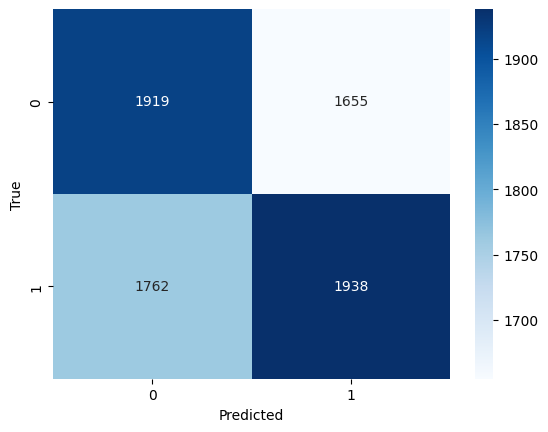

In [60]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

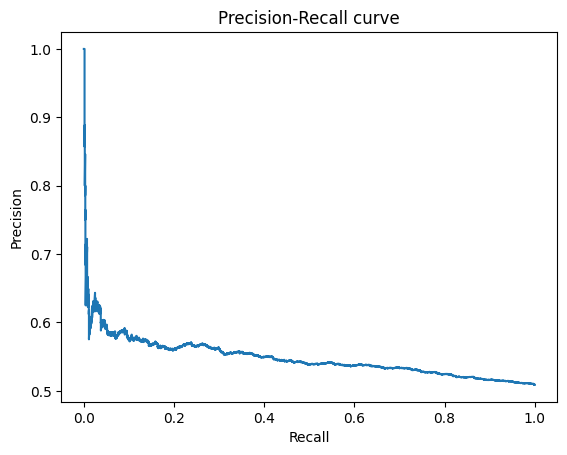

In [61]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

In [62]:
lgb_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbosity=-1)
scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validated accuracy:", scores.mean())

Cross-validated accuracy: 0.5071917564206239


Final tune_capital: 1033.8249056569307
Sharpe Ratio: 0.5691506775704624


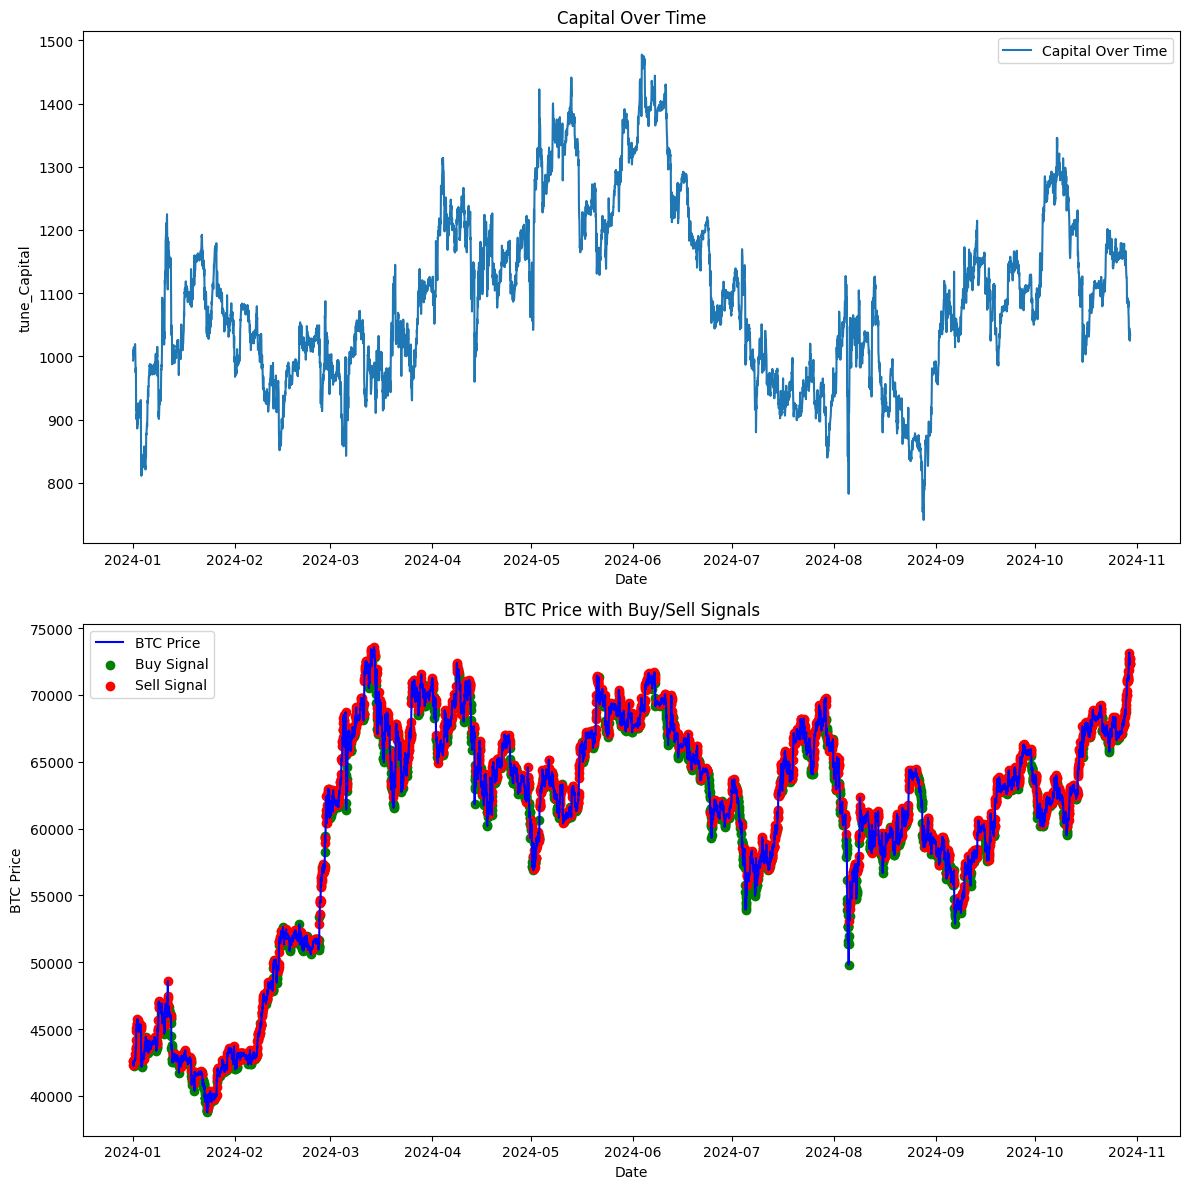

In [63]:
# バックテストの実行
# 取引シミュレーション
tune_capital = initial_capital  # 初期資金をリセット
capital_history = []
positions = []
buy_signals = []
sell_signals = []

for i in range(len(test_dates)-1):
    date = test_dates[i]
    prediction = y_pred[i]
    close_price = df.loc[date, 'close']
    next_date = test_dates[i+1]
    next_close_price = df.loc[next_date, 'close']
    
    # ポジションの決定
    if prediction == 1:
        position = 1  # ロング
        buy_signals.append((next_date, next_close_price))  # 買いのシグナル
    else:
        position = -1  # ショート
        sell_signals.append((next_date, next_close_price))  # 売りのシグナル
    
    # リターンの計算
    ret = (next_close_price - close_price) / close_price * position * leverage
    tune_capital = tune_capital * (1 + ret)
    capital_history.append(tune_capital)
    positions.append(position)

# バックテスト結果のデータフレーム作成
backtest_results = pd.DataFrame(index=test_dates[:-1])
backtest_results['tune_capital'] = capital_history
backtest_results['Position'] = positions

# リターンの計算
backtest_results['Return'] = backtest_results['tune_capital'].pct_change().fillna(0)

# シャープレシオの計算（リスクフリーレートは0と仮定）
tune_sharpe_ratio = (backtest_results['Return'].mean() / backtest_results['Return'].std()) * np.sqrt(365 * 24)

print('Final tune_capital:', tune_capital)
print('Sharpe Ratio:', tune_sharpe_ratio)

# 資産推移と売買のプロット
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# 1つ目のグラフ: 資産推移のプロット
plt.subplot(2, 1, 1)  # 2行1列のグラフの1番目
plt.plot(backtest_results.index, backtest_results['tune_capital'], label='Capital Over Time')
plt.title('Capital Over Time')
plt.xlabel('Date')
plt.ylabel('tune_Capital')
plt.legend()

# 2つ目のグラフ: BTC価格と売買シグナルのプロット
plt.subplot(2, 1, 2)  # 2行1列のグラフの2番目
plt.plot(df.loc[test_dates[:-1], 'close'], label='BTC Price', color='blue')

# 買いのシグナル（緑の丸）
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='o')

# 売りのシグナル（赤の丸）
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='o')

plt.title('BTC Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()

plt.tight_layout()
plt.show()

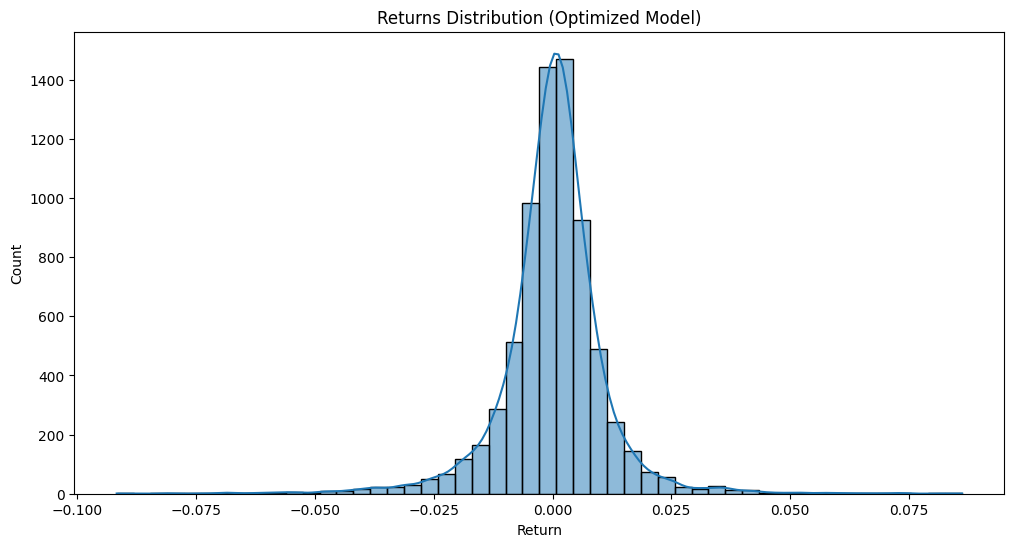

In [64]:
# リターン分布のプロット
plt.figure(figsize=(12,6))
sns.histplot(backtest_results['Return'], bins=50, kde=True)
plt.title('Returns Distribution (Optimized Model)')
plt.show()

In [65]:
backtest_results['Return']

timestamp
2024-01-01 00:00:00    0.000000
2024-01-01 01:00:00    0.001523
2024-01-01 02:00:00    0.011771
2024-01-01 03:00:00    0.003284
2024-01-01 04:00:00   -0.007829
                         ...   
2024-10-29 20:00:00   -0.001278
2024-10-29 21:00:00   -0.010237
2024-10-29 22:00:00   -0.002103
2024-10-29 23:00:00    0.012275
2024-10-30 00:00:00   -0.003469
Name: Return, Length: 7273, dtype: float64

In [66]:
# モデルの保存
gbm_optimized.save_model('lightgbm_btc_model_optimized.txt')

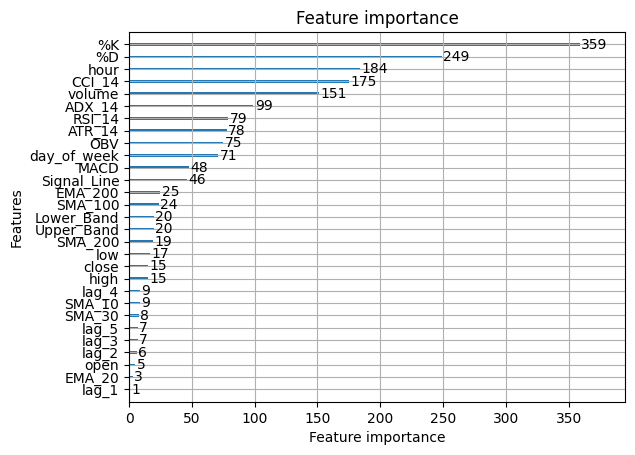

In [67]:
# 特徴量の重要度をプロット
lgb.plot_importance(gbm_optimized, max_num_features=1000)
plt.show()

In [68]:
# 保存するデータ
data = {'時間足':[timeframe], 'レバレッジ':[leverage], '特徴量' : [features], 'テスト開始時期' : [split_date], '精度' : [accuracy], 
        '最終資産' : [capital], 'シャープレシオ' : [sharpe_ratio], 'チューン後精度' : [tune_accuracy], 
        'チューン後最終資産' : [tune_capital], 'チューン後シャープレシオ' : [tune_sharpe_ratio]}

df_result = pd.DataFrame(data)

# 'result.csv'が既に存在するか確認
file_exists = os.path.isfile('result.csv')

# CSVファイルに追記、ファイルが既に存在する場合はヘッダーを追加しない
df_result.to_csv('result.csv', mode='a', header=not file_exists, index=False)

In [69]:
print('Final capital:', capital)
print('Final tune_capital:', tune_capital)

Final capital: 2151.0109260680556
Final tune_capital: 1033.8249056569307
